In [ ]:
!pip install tensorflow
!pip install tensorflow-federated


In [ ]:
import collections
import tensorflow as tf
import tensorflow_federated as tff

# Load simulation data.
source, _ = tff.simulation.datasets.emnist.load_data()
def client_data(n):
  return source.create_tf_dataset_for_client(source.client_ids[n]).map(
      lambda e: (tf.reshape(e['pixels'], [-1]), e['label'])
  ).repeat(10).batch(20)

# Pick a subset of client devices to participate in training.
train_data = [client_data(n) for n in range(3)]

# Wrap a Keras model for use with TFF.
keras_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(
    10, tf.nn.softmax, input_shape=(784,), kernel_initializer='zeros')
])
tff_model = tff.learning.models.functional_model_from_keras(
      keras_model,
      loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      input_spec=train_data[0].element_spec,
      metrics_constructor=collections.OrderedDict(
        accuracy=tf.keras.metrics.SparseCategoricalAccuracy))

# Simulate a few rounds of training with the selected client devices.
trainer = tff.learning.algorithms.build_weighted_fed_avg(
  tff_model,
  client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.1))
state = trainer.initialize()
for _ in range(5):
  result = trainer.next(state, train_data)
  state = result.state
  metrics = result.metrics
  print(metrics['client_work']['train']['accuracy'])

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


0.116
0.10109091
0.10290909
0.10290909
0.102545455


#Federated Learning Implementation

In [ ]:
import collections
import tensorflow as tf
import tensorflow_federated as tff

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the dataset (scale pixel values to [0, 1])
train_images = train_images / 255.0
test_images = test_images / 255.0

# Split the training data into 10 clients
NUM_CLIENTS = 10
client_data = []

for i in range(NUM_CLIENTS):
    start_idx = i * len(train_images) // NUM_CLIENTS
    end_idx = (i + 1) * len(train_images) // NUM_CLIENTS
    client_images = train_images[start_idx:end_idx]
    client_labels = train_labels[start_idx:end_idx]
    client_data.append((client_images, client_labels))

# Function to create TensorFlow dataset from client data
def create_tf_dataset(images, labels):
    return tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(100).batch(20)

# Create a list of federated datasets for each client
federated_train_data = [create_tf_dataset(images, labels) for images, labels in client_data]

# Create a simple Keras model
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Model function that wraps the Keras model into a TFF model
def model_fn():
    keras_model = create_keras_model()

    # Wrap the Keras model for TFF using a compatible wrapper
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Create a Federated Averaging process

trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),  # Pass the SGD optimizer instance, not function
)


# Initialize the federated learning state
state = trainer.initialize()

# Run federated training for a few rounds
NUM_ROUNDS = 5
for round_num in range(NUM_ROUNDS):
    result = trainer.next(state, federated_train_data)
    state = result.state
    metrics = result.metrics
    print(f'Round {round_num + 1}, Metrics: {metrics["client_work"]["train"]["sparse_categorical_accuracy"]}')


Round 1, Metrics: 0.7356166839599609
Round 2, Metrics: 0.870116651058197
Round 3, Metrics: 0.8889666795730591
Round 4, Metrics: 0.8980000019073486
Round 5, Metrics: 0.9051499962806702


In [ ]:
import collections
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow_privacy.privacy.dp_query import gaussian_query

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Convert images to float32 and normalize the dataset (scale pixel values to [0, 1])
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to int32
train_labels = train_labels.astype('int32')
test_labels = test_labels.astype('int32')

# Split the training data into 10 clients
NUM_CLIENTS = 10
client_data = []

for i in range(NUM_CLIENTS):
    start_idx = i * len(train_images) // NUM_CLIENTS
    end_idx = (i + 1) * len(train_images) // NUM_CLIENTS
    client_images = train_images[start_idx:end_idx]
    client_labels = train_labels[start_idx:end_idx]
    client_data.append((client_images, client_labels))

# Function to create TensorFlow dataset from client data
def create_tf_dataset(images, labels):
    return tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(100).batch(20)

# Create a list of federated datasets for each client
federated_train_data = [create_tf_dataset(images, labels) for images, labels in client_data]

# Create a simple Keras model
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# Model function that wraps the Keras model into a TFF model
def model_fn():
    keras_model = create_keras_model()

    # Wrap the Keras model for TFF using a compatible wrapper
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Set up DP parameters
l2_norm_clip = 1.0  # Clip gradients to this L2 norm
stddev = 1.0  # Standard deviation of Gaussian noise for DP

# Initialize GaussianAverageQuery for DP
dp_query = gaussian_query.GaussianSumQuery(
    l2_norm_clip=l2_norm_clip,
    stddev=stddev
)

# Initialize global state for DP
global_state = dp_query.initial_global_state()

# Define number of rounds
NUM_ROUNDS = 5

# Federated training loop with DP
for round_num in range(NUM_ROUNDS):
    # Derive sample params for this round
    sample_params = dp_query.derive_sample_params(global_state)

    # Get the shape of client updates from the first batch of data
    example_batch = next(iter(federated_train_data[0]))  # Fetch a sample batch to get the shape
    sample_state = dp_query.initial_sample_state(tf.nest.map_structure(lambda x: tf.zeros_like(x), example_batch[0]))  # Use only images, exclude labels

    # Accumulate records (client updates) for the round
    for client_data in federated_train_data:
        client_dataset = client_data
        for batch in client_dataset:
            images, labels = batch  # Separate images and labels

            # Only use images (float32) for DP accumulation
            sample_state = dp_query.accumulate_record(
                sample_params, sample_state, images  # Pass images only
            )

    # Get the noised result (differentially private updates)
    noised_result = dp_query.get_noised_result(sample_state, global_state)
    #result, global_state = noised_result[0], noised_result[1]

    # Print or use the result for federated training updates
    print(f"Round {round_num + 1}, Noised Result: {result}")


    # Proceed with federated training, using the DP-processed result for model updates

# Initialize the federated learning state
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),  # Pass the SGD optimizer instance, not function
)


state = trainer.initialize()

# Run federated training rounds with DP-applied updates
for round_num in range(NUM_ROUNDS):
    result = trainer.next(state, federated_train_data)
    state = result.state
    metrics = result.metrics
    print(f'Round {round_num + 1}, Metrics: {metrics["client_work"]["train"]["sparse_categorical_accuracy"]}')


Round 1, Noised Result: LearningProcessOutput(state=LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[ 0.00076903,  0.01452828, -0.07290555, ...,  0.00535234,
        -0.0014576 , -0.04849723],
       [ 0.03733986, -0.00354999, -0.00705577, ...,  0.0031126 ,
        -0.04408117,  0.00149909],
       [ 0.04116818, -0.04099673, -0.07325702, ...,  0.03407957,
         0.00961365, -0.04735346],
       ...,
       [-0.06885487,  0.03683484,  0.07141627, ..., -0.0327275 ,
         0.04880738,  0.03733102],
       [-0.04473045, -0.01709906, -0.06657119, ..., -0.00947399,
        -0.0701832 , -0.0457263 ],
       [-0.00920554, -0.00988638, -0.05957656, ...,  0.07630164,
         0.03484969,  0.0616454 ]], dtype=float32), array([ 0.0295772 ,  0.04938458,  0.00895964,  0.02973482,  0.02162057,
        0.00268637, -0.00543929,  0.01799041,  0.00848877, -0.03400663,
       -0.00755139,  0.0108763 ,  0.03337883,  0.03050668,  0.05978568,
        0.00498149,  0.02915595, -0

In [ ]:
dp_mean = tff.aggregators.DifferentiallyPrivateFactory.gaussian_adaptive(
    noise_multiplier=0.1, clients_per_round=100)

# Equivalent to:
# dp_mean = tff.learning.dp_aggregator(
#   noise_multiplier=0.1, clients_per_round=100, zeroing=False)

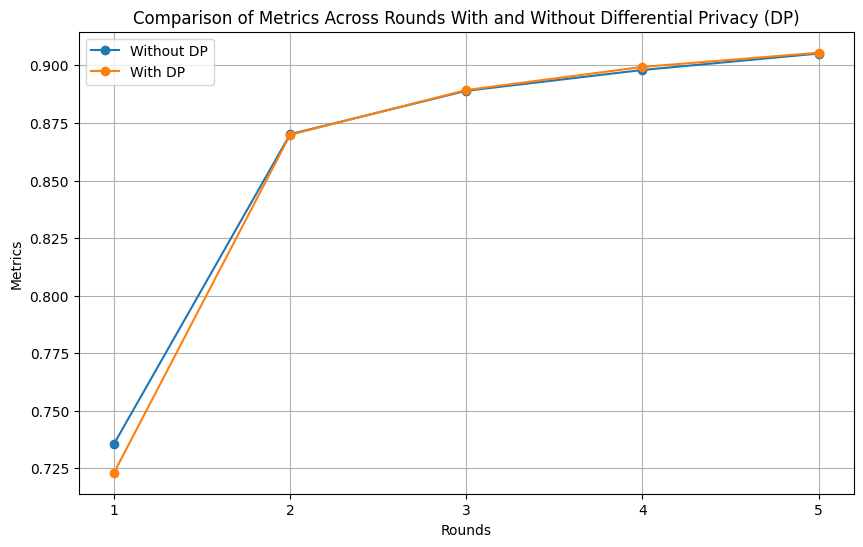

In [ ]:
import matplotlib.pyplot as plt

# Data for each round
rounds = [1, 2, 3, 4, 5]
without_dp = [0.7356166839599609, 0.870116651058197, 0.8889666795730591, 0.8980000019073486, 0.9051499962806702]
with_dp = [0.7231000065803528, 0.86986669178009, 0.8892833590507507, 0.8993333578109741, 0.9054999947547913]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, without_dp, marker='o', linestyle='-', label='Without DP')
plt.plot(rounds, with_dp, marker='o', linestyle='-', label='With DP')

# Adding labels and title
plt.xlabel('Rounds')
plt.ylabel('Metrics')
plt.title('Comparison of Metrics Across Rounds With and Without Differential Privacy (DP)')
plt.xticks(rounds)  # Ensure x-axis shows round numbers
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
